### MACHINE LEARNING 
### NAME: Kshitij Chilate
### DATE: 16/10/2025

### Step 1. Setup and Data Loading

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

try:
    df = pd.read_csv('application_data.csv')
except FileNotFoundError:
    print("Error: 'application_data.csv' not found. Please place it in the correct directory.")
    exit()

df_sample = df.sample(n=20000, random_state=42)

print("Shape of the full dataset:", df.shape)
print("Shape of the sampled dataset:", df_sample.shape)

Shape of the full dataset: (307511, 122)
Shape of the sampled dataset: (20000, 122)


### Step 2. Exploratory Data Analysis (EDA)

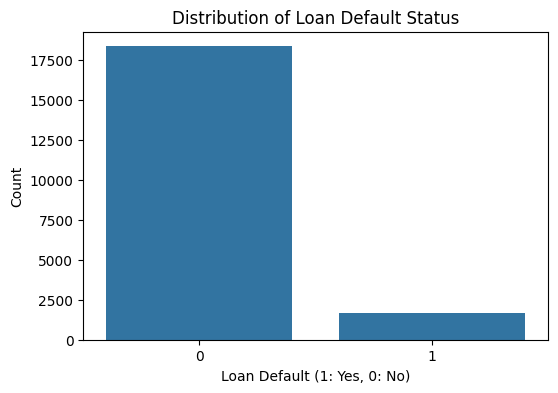

Target Variable Distribution:
TARGET
0    91.77
1     8.23
Name: proportion, dtype: float64


In [37]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=df_sample)
plt.title('Distribution of Loan Default Status')
plt.xlabel('Loan Default (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

print("Target Variable Distribution:")
print(df_sample['TARGET'].value_counts(normalize=True) * 100)

### Step 3. Data Preprocessing

In [38]:
features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'
]
target = 'TARGET'

X = df_sample[features]
y = df_sample[target]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=object).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Step 4. Train & Evaluate Baseline Models

In [39]:
# --- Random Forest Baseline ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("--- Random Forest Baseline Performance ---")
print(classification_report(y_test, y_pred_rf))

# --- SVM Baseline ---
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(random_state=42))])
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("\n--- SVM Baseline Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

--- Random Forest Baseline Performance ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3671
           1       0.00      0.00      0.00       329

    accuracy                           0.92      4000
   macro avg       0.46      0.50      0.48      4000
weighted avg       0.84      0.92      0.88      4000


--- SVM Baseline Performance ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3671
           1       0.00      0.00      0.00       329

    accuracy                           0.92      4000
   macro avg       0.46      0.50      0.48      4000
weighted avg       0.84      0.92      0.88      4000



### Step 5. Hyperparameter Tuning

In [40]:
# --- Random Forest Hyperparameter Tuning ---
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', None]
}
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid_search_rf.fit(X_train, y_train)
print("\n--- Tuned Random Forest Best Parameters ---")
print(grid_search_rf.best_params_)

# --- SVM Hyperparameter Tuning ---
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale'],
    'classifier__class_weight': ['balanced', None]
}
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid_search_svm.fit(X_train, y_train)
print("\n--- Tuned SVM Best Parameters ---")
print(grid_search_svm.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Tuned Random Forest Best Parameters ---
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- Tuned SVM Best Parameters ---
{'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__gamma': 'scale'}


### Step 6. Final Model Evaluation & Comparison

In [41]:
# Evaluate the best Random Forest model
best_rf = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
print("\n--- Random Forest Tuned Performance ---")
print(classification_report(y_test, y_pred_rf_tuned))

# Evaluate the best SVM model
best_svm = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test)
print("\n--- SVM Tuned Performance ---")
print(classification_report(y_test, y_pred_svm_tuned))

# --- Final Comparison Table ---
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (1)': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'Recall (1)': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'F1-Score (1)': f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    }

results = {
    'Baseline Random Forest': get_metrics(y_test, y_pred_rf),
    'Tuned Random Forest': get_metrics(y_test, y_pred_rf_tuned),
    'Baseline SVM': get_metrics(y_test, y_pred_svm),
    'Tuned SVM': get_metrics(y_test, y_pred_svm_tuned),
}

results_df = pd.DataFrame(results).T
print("\n--- Final Model Comparison ---")
print(results_df)


--- Random Forest Tuned Performance ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3671
           1       0.18      0.01      0.02       329

    accuracy                           0.92      4000
   macro avg       0.55      0.50      0.49      4000
weighted avg       0.86      0.92      0.88      4000


--- SVM Tuned Performance ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3671
           1       0.00      0.00      0.00       329

    accuracy                           0.92      4000
   macro avg       0.46      0.50      0.48      4000
weighted avg       0.84      0.92      0.88      4000


--- Final Model Comparison ---
                        Accuracy  Precision (1)  Recall (1)  F1-Score (1)
Baseline Random Forest   0.91650       0.000000    0.000000      0.000000
Tuned Random Forest      0.91500       0.176471    0.009119      0.017341
Baseline SVM        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
